# Transient forward inverse rendering (Staircase scene)

<div class="admonition important alert alert-block alert-warning">

This tutorial is exactly the same as `forward_inverse_rendering_cbox.ipynb`. There are two main changes:

1. This uses a more complex `staircase` scene. Executing this example requires a lot of RAM memory (>>32GB). If your computer cannot handle this requirement you can use the Cornell Box which is cheaper.
2. This scene uses `camera_unwarp=True` for the integrator. That means that, when computing the time of flight, the distance from the last bounce to the camera is not taken into account. This has the effects that you see events happening in world time instead of camera time (i.e. when they are observed by a camera located at a distance).

</div>

## Overview
This tutorial deals with one of the two forms of inverse rendering: *forward* inverse rendering, in the transient domain. Mathematically, consider $\textbf{x}$ as your set of scene parameters (e.g. material properties, albedos...). Our transient path tracing algorithms are functions $f$ that transform them into a time-resolved image $\textbf{y}$. Given that we are in the transient domain:
$$
\textbf{y}(t) = f(\textbf{x}, t)
$$
With this formulation, **forward mode differentiation** allows you to compute $\frac{\partial \textbf{y}(t)}{\partial \textbf{x}_i}$ for **one** parameter $\textbf{x}_i \in \textbf{x}$ of the scene parameters. As you will see, the forward mode is very useful to generate visualizations of the effect of individual scene parameters. However if you plan to optimize scene parameters, you'll probably want to look into 

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn:**

<ul>
  <li>
  
  What is *forward inverse rendering* and why it is useful
  
  </li>
  <li>
  
  How to compute *transient* forward mode derivatives for a given scene parameter
  
  </li>
  <li>
  
  Visualize the output video and understand what it represents
  
  </li>
</ul>

</div>

## Importing mitransient

You need to use a Mitsuba variant that enables Automatic Differentiation (AD). Any `*_ad_*` variant will do. Common choices should be `llvm_ad_rgb` for CPU and `cuda_ad_rgb` for GPU.

In [1]:
# If you have compiled Mitsuba 3 yourself, you will need to specify the path
# to the compilation folder
# import sys
# sys.path.insert(0, '<mitsuba-path>/mitsuba3/build/python')
import mitsuba as mi
# To set a variant, you need to have set it in the mitsuba.conf file
# https://mitsuba.readthedocs.io/en/latest/src/key_topics/variants.html
mi.set_variant('llvm_ad_rgb')

import mitransient as mitr
import drjit as dr

print('Using mitsuba version:', mi.__version__)
print('Using Dr.JIT version:', dr.__version__)
print('Using mitransient version:', mitr.__version__)

Using mitsuba version: 3.7.0
Using Dr.JIT version: 1.1.0
Using mitransient version: 1.2.0




Forward mode differentiable rendering begins analogously to reverse mode, by marking the parameters of interest as differentiable (in this example, we do so manually instead of using an `Optimizer`). 

Our goal here is to visualize how changes of the green wall's color affect the final rendered image. Note that we are rendering this image using a physically-based *path tracer*, which means that it accounts for globlal illumination, reflection, refraction, and so on. Gradients computated from this simulation will also expose such effects.

## Preparing the scene

We load the same Cornell Box as most other examples. As will be seen later it'll be useful to start recording the video a bit earlier (the original value of `start_opl` was 3.5, now it is 3). For more information about this parameter you can check the documentation for `transient_hdr_film`.

In [2]:
scene = mi.load_file('staircase/scene.xml')

Using the `mi.traverse` function will give a list of all parameters that can be differentiated. You should look for parameters with the `∂` symbol. `D` means ns that there are discontinuities involved and, in practice, computation of these gradients can be very noisy/incorrect sometimes.

In [3]:
params = mi.traverse(scene)

params

SceneParameters[
  ---------------------------------------------------------------------------------------------------------------------------
  Name                                                                    Flags    Type                    Parent
  ---------------------------------------------------------------------------------------------------------------------------
  allow_thread_reordering                                                          bool                    Scene
  object_108478955067552.near_clip                                                 float                   PerspectiveCamera
  object_108478955067552.far_clip                                                  float                   PerspectiveCamera
  object_108478955067552.shutter_open                                              float                   PerspectiveCamera
  object_108478955067552.shutter_open_time                                         float                   PerspectiveCamera
  ob

We select the `red.reflectance.value`, which refers to how much light the red wall (on the left of the scene) reflects.

**Importantly, we mark this parameter for gradient tracking, which will allow to compute the derivatives of the image pixels with respect to this parameter later.**

In [4]:
key = 'WoodChairBSDF.brdf_0.alpha'

# Mark the green wall color parameter as differentiable
dr.enable_grad(params[key])

# Propagate this change to the scene internal state
params.update();

## Rendering

We can then perform the simulation to be differentiated. In this case, we simply render an image using the `mi.render()` routine, which will in turn call the scene's path tracer integrator.

As we have marked the wall color as *differentiable*, its role in the rendering process is recorded in the autodiff graph.

**For now we are not computing any derivatives, this is exactly the same as the standard render tutorials. However, take note of the order of events in the transient video (first the light at the top lights up, then other elements of the scene, etc.)**

In [5]:
result = mi.render(scene, params, spp=1024)  # we use more SPP so the transient result is less noisy

In [6]:
mi.util.convert_to_bitmap(result[0])

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [720, 1280],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 2.64 MiB of image data ]
]

In [7]:
transient_tonemap = mitr.vis.tonemap_transient(result[1])
mitr.vis.show_video(transient_tonemap, axis_video=2)

## Computing gradients

The [<code>dr.forward()</code>][1] function will assign a gradient value of `1.0` to the given variables and forward-propagate those gradients through the previously recorded computation graph. During this process, gradient will be accumulated in the output nodes of this graph (here, the rendered image).

Finally, the gradients can be read using [<code>dr.grad()</code>][2].

For more detailed information about differentiation with DrJit, please refer to the [documentation][3].

<div class="admonition important alert alert-block alert-warning">

**Important detail:** Note how, when using a transient integrator, the `mi.render` function returns two objects (steady state + transient images). That is just a tuple of two objects. You need to pass that same tuple to `dr.grad()`.

</div>

[1]: https://drjit.readthedocs.io/en/latest/reference.html#drjit.forward
[2]: https://drjit.readthedocs.io/en/latest/reference.html#drjit.grad
[3]: https://drjit.readthedocs.io/en/latest

In [8]:
# Forward-propagate gradients through the computation graph
dr.forward(params[key])

# Fetch the image gradient values
grad_image, grad_video = dr.grad(result)

## Visualizing the result (steady state)

You get two results: the steady state gradients (the same as in Mitsuba 3), and the transient gradients. First let's look at the steady state. Because we are tracking changes in the image from a red wall, the gradient is higher on the red channel. You can see all points of the image affected by the red wall. As you may have thought, points closer to the red wall have higher derivatives as the red color bleeding is higher for them.

Note however that gradient values are not necessarily within the `[0, 1]` range, and so it makes more sense to use a color map and visualize each color channel of the gradient image individually.

Remapping colors within range: [-1.74, 1.74]


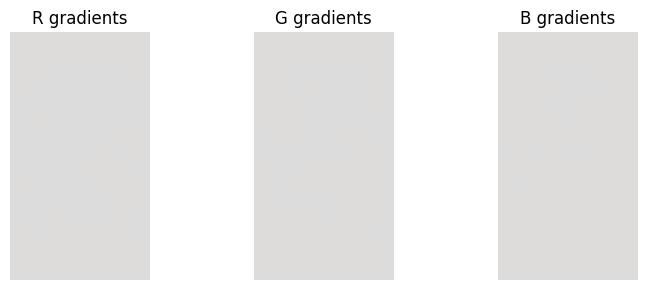

In [9]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm

cmap = cm.coolwarm
vlim = dr.max(dr.abs(grad_image).array)[0]
print(f'Remapping colors within range: [{-vlim:.2f}, {vlim:.2f}]')

fig, axx = plt.subplots(1, 3, figsize=(8, 3))
for i, ax in enumerate(axx):
    ax.imshow(grad_image[..., i], cmap=cm.coolwarm, vmin=-vlim, vmax=vlim)
    ax.set_title('RGB'[i] + ' gradients')
    ax.axis('off')
fig.tight_layout()
plt.show()

Finally, the transient gradient shows when these changes in brightness would take place. Consider one point on the red wall. The time at which its changes would reach the camera is just the time of flight from that point to the camera sensor. So you might think about what happens in this video as:
1. At $t=0$ every point in the red wall emits "derivative light"
2. This "derivative light" propagates through the scene just as normal light would do.
3. When it reaches the camera, this derivative light is stored in `grad_video` with its corresponding time of flight.

In [10]:
grad_video_tonemap = mitr.vis.tonemap_grad_transient(grad_video)

mitr.vis.show_video(grad_video_tonemap)